# NOCKO III - Distribution mixture classification

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader, TensorDataset
from torch.distributions import multivariate_normal, binomial
from sklearn import datasets
import numpy as np
from torch.autograd import Variable
import ipdb
from sklearn.mixture import GaussianMixture
from torchdiffeq import odeint, odeint_adjoint
from tqdm import tqdm
random_seed = 0
n_samples = 400
import time
np.random.seed(random_seed)
plt.style.use('seaborn-talk')

ImportError: No module named 'torchdiffeq'

## Utils

In [124]:
def phase_evol(phases, masks, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    #phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    plt.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        plt.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
        #plt.ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            plt.plot(phases[:, i])
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name + '.png')
    else:
        plt.show()
    plt.close()

## Dataset generators ##

### Blobs

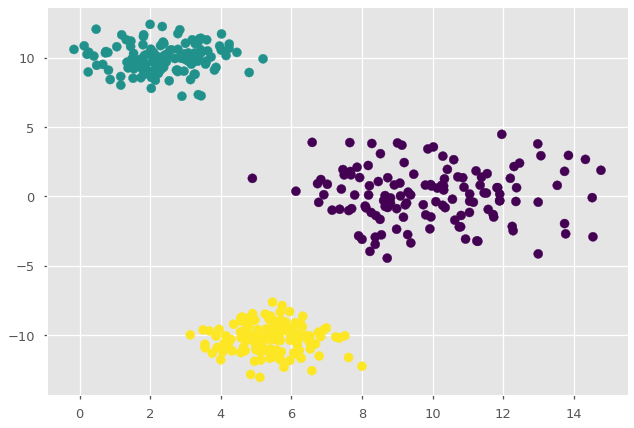

In [125]:
blobs = datasets.make_blobs(n_samples=n_samples,
                             centers =[[10,0], [2.5,10], [5.5,-10]],
                             cluster_std = [2,1,1],
                             random_state=random_seed)
plt.scatter(blobs[0][:,0], blobs[0][:,1], c=blobs[1])
plt.show()

### Circles

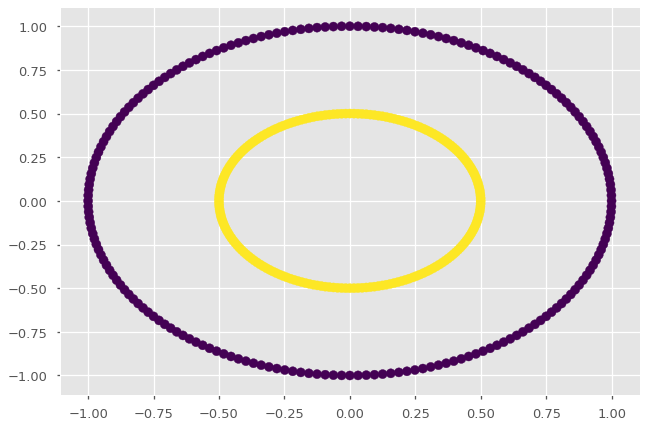

In [18]:
circles = datasets.make_circles(n_samples=n_samples,
                             factor=0.5,
                             random_state=random_seed)
plt.scatter(circles[0][:,0], circles[0][:,1], c=circles[1])
plt.show()

### Moons

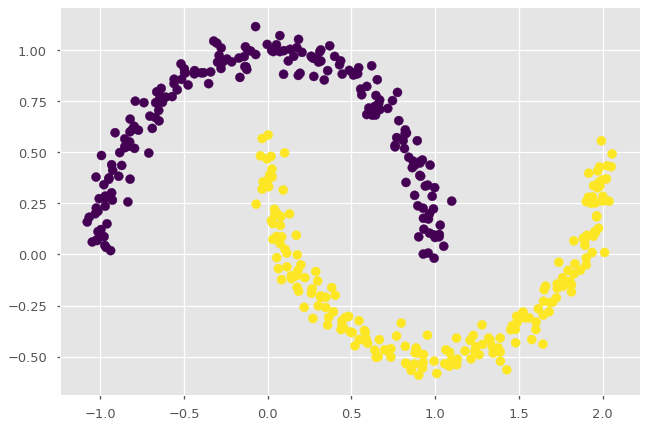

In [19]:
moons = datasets.make_moons(n_samples=400,
                            noise = 0.05,
                             random_state=random_seed)
plt.scatter(moons[0][:,0], moons[0][:,1], c=moons[1])

### Gaussian mixture generator

In [20]:
class GMM(object):
    def __init__(self, n_components, centroids, cov_matrices):
        self.n_components = n_components
        self.centroids = centroids
        self.cov_matrices = cov_matrices
        
    def one_sampling(self,statistics):
        return np.random.multivariate_normal(statistics[0], statistics[1])
        
    def sample(self, n_samples):
        idx = np.random.randint(0, self.n_components,n_samples)
        list_stat = [[self.centroids[i],self.cov_matrices[i]] for i in idx]
        return [torch.tensor((np.vstack(list(map(self.one_sampling,list_stat))))), torch.tensor(idx)]
    
    def train_test(self,n_samples_train,n_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)

elapsed time  0.2609281539916992


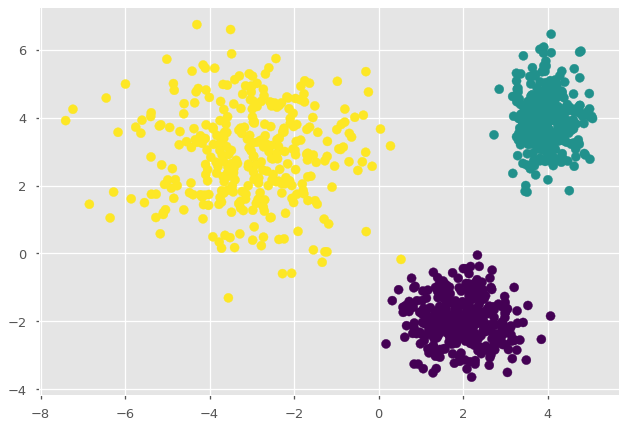

In [21]:
gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-3,3]], cov_matrices=[0.5*np.eye(2),0.2*np.diag([1,3]),2*np.eye(2)])
#gmm = GMM(n_components=2, centroids=[[2,-2],[2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
start= time.time()
a, idx = gmm.sample(1000)
print('elapsed time ', time.time() - start)
plt.scatter(a[:,0],a[:,1],c=idx)
plt.show()

## Loss

In [1]:
def circular_moments_batch(phases, masks, lasts=50, split = False):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    #burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(1) * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    desynch = 0
    #for m in np.arange(1, int(np.floor(num_groups/2.)) + 1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        #desynch += (1.0/m) * (torch.cos(m*masked_phases).sum(-1)**2 + torch.sin(m*masked_phases).sum(-1)**2)
    #    desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    
    for m in range(1,num_groups):
        desynch += (1.0 / 2*num_groups*m**2) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    desynch += (1.0 / 2*num_groups*num_groups**2) * (torch.cos(num_groups*mean_angles).sum(-1)**2 + torch.sin(num_groups*mean_angles).sum(-1)**2)
        
    loss = .5*(synch + desynch)[-lasts:,...]
    
    if split == True:
        return loss[-lasts:,...].mean(), synch[-lasts:,...].mean(), desynch[-lasts:,...].mean()
    else:
        return loss.mean()

In [23]:
def cohn_loss(phases, masks, lasts=50, split = False):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    masked_phases = phases.unsqueeze(1) * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.mean(1)
    
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    phase_diffs = mean_angles.unsqueeze(2) - mean_angles.unsqueeze(1)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + 1e-12)) + np.log(2)).sum((1,2)) / (num_groups)**2
    loss = .5*(synch + desynch)[-lasts:]
    if split == True:
        return loss[-lasts:,...].mean(), synch[-lasts:,...].mean(), desynch[-lasts:,...].mean()
    else:
        return loss.mean()

In [24]:
phase_splate = torch.tensor(np.tile([i*2*np.pi/3 for i in range(3)],100)).unsqueeze(0)
idx = torch.tensor(np.tile([i for i in range(3)],100))

mask_splate = torch.FloatTensor(300,3).zero_()
mask_splate.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
phase_splate_noise = phase_splate + 0.1*torch.normal(0,1,[300])

phase_noise = torch.normal(0,6,[1,300]).float()
phase_one = torch.ones(1,300).float()


In [25]:
circular_moments_batch(phase_noise,mask_splate,split = True)

(tensor(6.7392), tensor(0.9180), tensor(12.5604))

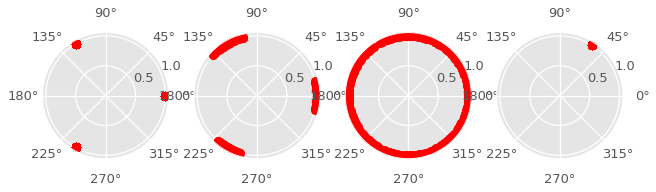

(tensor(4.1600e-30, dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(8.3200e-30, dtype=torch.float64))
(tensor(0.0117, dtype=torch.float64), tensor(0.0050, dtype=torch.float64), tensor(0.0183, dtype=torch.float64))
(tensor(6.7392), tensor(0.9180), tensor(12.5604))
(tensor(33.7500), tensor(5.9605e-08), tensor(67.5000))


In [26]:
fig,ax = plt.subplots(1,4,subplot_kw=dict(projection='polar'))
ax[0].plot(phase_splate,np.ones(len(phase_splate)),'ro')
ax[1].plot(phase_splate_noise,np.ones(len(phase_splate)),'ro')
ax[2].plot(phase_noise,np.ones(len(phase_splate)),'ro')
ax[3].plot(phase_one,np.ones(len(phase_splate)),'ro')
plt.show()

print(circular_moments_batch(phase_splate,mask_splate,split = True))
print(circular_moments_batch(phase_splate_noise,mask_splate,split = True))
print(circular_moments_batch(phase_noise,mask_splate,split = True))
print(circular_moments_batch(phase_one,mask_splate,split = True))

The two terms of the loss function (synch and desynch) appears to have the right behaviors depending on the special oscillator arrangements tested

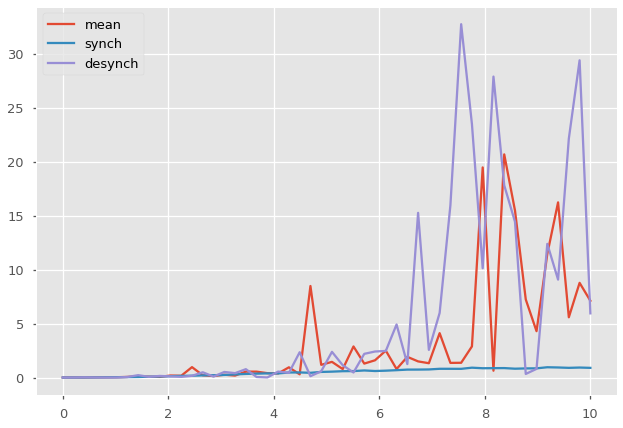

In [27]:
range_ =  np.linspace(0,10,50)
plt.plot(range_,[circular_moments_batch(phase_splate + k*torch.normal(0,0.25,[300]),mask_splate,split = True)[0].numpy() for k in range_],label='mean')
plt.plot(range_,[circular_moments_batch(phase_splate + k*torch.normal(0,0.25,[300]),mask_splate,split = True)[1].numpy() for k in range_],label='synch')
plt.plot(range_,[circular_moments_batch(phase_splate + k*torch.normal(0,0.25,[300]),mask_splate,split = True)[2].numpy() for k in range_],label='desynch')
plt.legend()
plt.show()

The evolution of the two terms as a function of clusters "width" when close to splate states.

## Initial Model formulation

In [28]:
class coupling_net(torch.nn.Module):
    def __init__(self, num_in, num_hid=256, out_dim=10):
        super(coupling_net, self).__init__()
        self.out_dim = out_dim
        self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid),
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(num_hid,num_hid),
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(num_hid,out_dim))
#        self.layers = torch.nn.Linear(num_in, out_dim)

    def forward(self,x):
        features = self.layers(x)
        return features #torch.einsum('bi,ci->bc',features,features) * (1. / self.out_dim)

In [29]:
class KuraODE(nn.Module):
    
    """
    torch.nn.Module that defines the infinitesimal evolution of the ODE : df/dt = module(t,\theta)
    - Handles batchs of images by flattening the batch dim and treat everything as a single ODE
    - Requires the update of the couplings parameters at every call to get the gradient d(couplings)/dL
    """
    
    def __init__(self):
        super(KuraODE, self).__init__()
        #self.couplings = torch.nn.Parameter(torch.eye(1),requires_grad=True) #placeholder

    def update(self, couplings):
        self.couplings = torch.nn.Parameter(couplings,requires_grad=True)
        self.nfe = 0

    def forward(self, t, phase):
        self.nfe+=1
        phase = phase.reshape(self.couplings.shape[0],-1).float()
        n = self.couplings.shape[0]
        delta_phase = (self.couplings.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
        self.couplings.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 

        return delta_phase.squeeze(-1)
    

In [30]:
class Kuramoto(nn.Module):
    """
    Kuramoto dynamics with adaptative solver
    """
    def __init__(self,
                 batch_size = 32,
                 num_hid = 32,
                 feature_size = 10,
                 device='cpu'):
        
        super(Kuramoto, self).__init__()
  
        #Integration parameters
        self.integration_time =  torch.linspace(0., 10, 100).float()
        self.ODEDynamic = KuraODE()
        self.tol = 1e-5
        self.atol = 1e-5
        self.max_steps = 1000
        
        #Problem dimensions
        self.batch_size = batch_size
        self.indim = batch_size*feature_size
        self.outdim = batch_size*batch_size
        self.device = device

        # Definition of coupling inference model
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.indim, num_hid),
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(num_hid,num_hid),
                          torch.nn.Sigmoid(),             
                          torch.nn.Linear(num_hid,self.outdim))
        
    def forward(self,init_phase, x):
        
        #Infer couplings 
        couplings = self.layers(x.reshape(1,-1)).reshape(self.batch_size,self.batch_size)
        self.couplings = couplings
        self.ODEDynamic.update(couplings)
        
        #Run Dynamic with adaptative solver
        features = odeint_adjoint(self.ODEDynamic, init_phase, self.integration_time,
                                 rtol=self.tol, atol=self.atol, method='euler')
        
        return features, couplings

In [167]:
class KuraTrainer(object):
    def __init__(self, model, data_generator, batch_size, LossFunc, num_features=32):
        super(KuraTrainer, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.num_features=num_features
        self.model = model
        
    def init_phase(self,batch_size):
        #self.init = torch.zeros((batch_size,)).float().unsqueeze(0)
        self.init = torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0)
        #self.init = torch.FloatTensor(batch_size,).uniform_(0, 2*np.pi).unsqueeze(0)
        return self.init
        #return torch.normal(np.pi,0.05,(batch_size,)).float().unsqueeze(0)
    
    
    def plot_data(self,num_points):
        a, idx = self.data_generator.sample(num_points)
        plt.scatter(a[:,0],a[:,1],c=idx)
        plt.show()
    
    def train(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False, eps=1e-12,num_loss=0):
        self.lh = []
        opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.init_phase(self.batch_size)
        for _ in range(gradient_steps):
            
            #Sample data
            batch, idx = self.data_generator.sample(self.batch_size)
            masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
            init_phase = self.init
            
            #Training by gradient descent via adjoint sensitivity method
            opt.zero_grad()
            phase, couplings = self.model(init_phase, batch.float())
            loss = LossFunc(phase, masks,split=True)
            print(' step : ', _,'Loss : ', loss)
            self.lh.append(loss[num_loss].detach().numpy())
            
            loss[num_loss].backward()
            
            print(torch.pow(self.model.ODEDynamic.couplings.grad,2).sum())
        
            
            self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
            opt.step()
            #print(self.model.layers[2].weight.grad)
        return
    
    def phase_evol(self,phase, mask):
        return

In [32]:
bs = 100
Model = Kuramoto(batch_size = bs, num_hid = 200, feature_size=2, device='cpu')
gmm = GMM(n_components=4, centroids=[[2,-2],[4,4],[-3,3],[-2,-5]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,3]),0.02*np.eye(2),0.01*np.eye(2)])
#gmm = GMM(n_components=2, centroids=[[2,-2],[2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
LossFunc = circular_moments_batch
Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)

In [33]:
Trainer.train(gradient_steps=30)

 step :  0 Loss :  (tensor(104.5460, grad_fn=<MeanBackward0>), tensor(0.3561, grad_fn=<MeanBackward0>), tensor(208.7358, grad_fn=<MeanBackward0>))
tensor(963.9758)
 step :  1 Loss :  (tensor(34.0828, grad_fn=<MeanBackward0>), tensor(0.8901, grad_fn=<MeanBackward0>), tensor(67.2755, grad_fn=<MeanBackward0>))
tensor(13419.0645)
 step :  2 Loss :  (tensor(55.4920, grad_fn=<MeanBackward0>), tensor(0.8961, grad_fn=<MeanBackward0>), tensor(110.0879, grad_fn=<MeanBackward0>))
tensor(3485.2559)
 step :  3 Loss :  (tensor(105.3937, grad_fn=<MeanBackward0>), tensor(0.8468, grad_fn=<MeanBackward0>), tensor(209.9406, grad_fn=<MeanBackward0>))
tensor(24.5070)
 step :  4 Loss :  (tensor(49.1033, grad_fn=<MeanBackward0>), tensor(0.8540, grad_fn=<MeanBackward0>), tensor(97.3526, grad_fn=<MeanBackward0>))
tensor(854.1279)
 step :  5 Loss :  (tensor(69.3956, grad_fn=<MeanBackward0>), tensor(0.8636, grad_fn=<MeanBackward0>), tensor(137.9274, grad_fn=<MeanBackward0>))
tensor(9.3634)
 step :  6 Loss :  (te

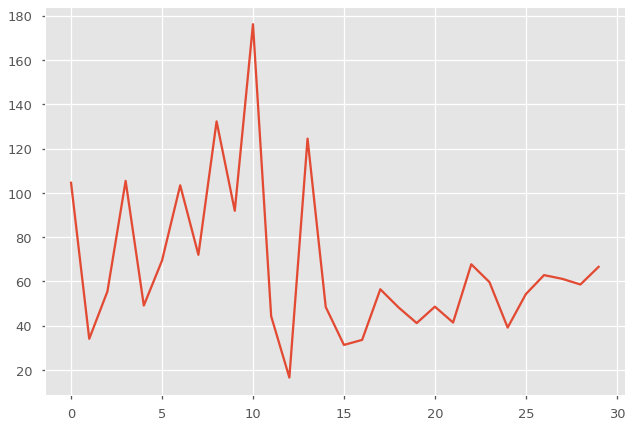

In [34]:
plt.plot(Trainer.lh)
plt.show()

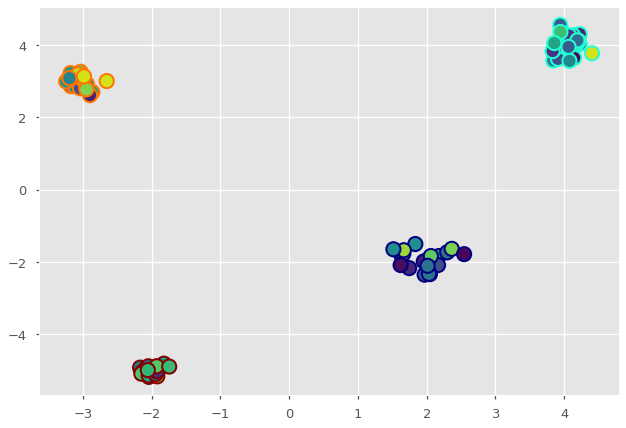

In [35]:
from matplotlib import cm
a,idx = gmm.sample(bs)
ecolors = [cm.jet(x*100) for x in idx]
init_phase = torch.normal(np.pi,0.05,(bs,)).float().unsqueeze(0)
freq = Model(init_phase,a.float())[0][-1]
colors = [cm.viridis(x) for x in (freq.squeeze(0).detach().numpy()%(2*np.pi))/(2*np.pi)]
plt.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)

In [36]:
a,idx = gmm.sample(bs)
masks = torch.FloatTensor(bs,4).zero_()
masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
init_phase = torch.normal(np.pi,0.05,(bs,)).float().unsqueeze(0)
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
Trainer.init_phase(bs)
features, couplings  = Model(Trainer.init,a.float())


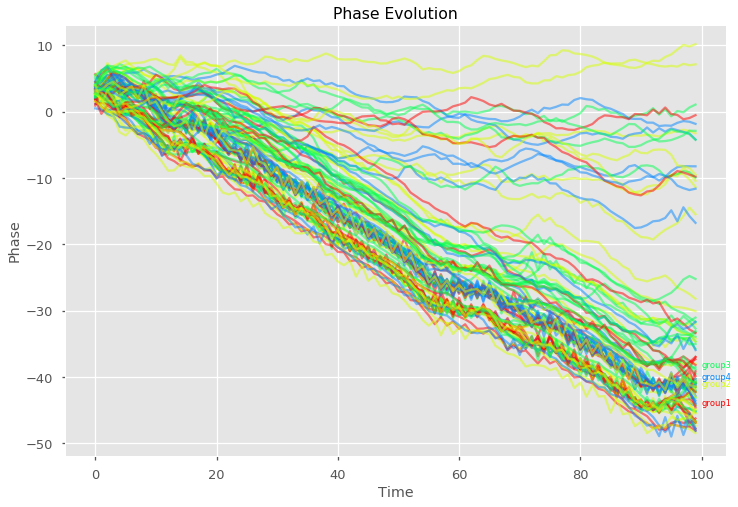

In [37]:
phase_evol(features.detach(),masks.unsqueeze(0).data.numpy())

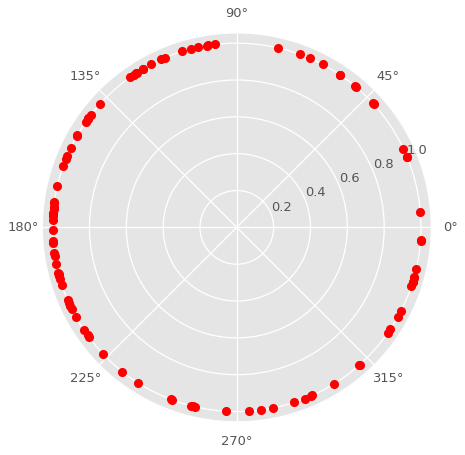

In [38]:
fig,ax = plt.subplots(1,1,subplot_kw=dict(projection='polar'))
ax.plot(features[-1].detach().numpy(),np.ones(len(phase_splate)),'ro')
plt.show()

## Model as feature extraction

In [232]:
class Kuramoto_features(nn.Module):
    """
    Kuramoto dynamics with adaptative solver
    """
    def __init__(self,
                 batch_size = 32,
                 num_hid = 32,
                 input_size = 2,
                 feature_size = 10,
                 device='cpu'):
        
        super(Kuramoto_features, self).__init__()
  
        #Integration parameters
        self.integration_time =  torch.linspace(0., 50, 100).float()
        self.ODEDynamic = KuraODE()
        self.tol = 1e-5
        self.atol = 1e-5
        self.max_steps = 1000
        
        #Problem dimensions
        self.batch_size = batch_size
        self.indim = input_size
        self.outdim = feature_size
        self.device = device

        # Definition of coupling inference model
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.indim, num_hid),
                          torch.nn.ReLU(),
                          torch.nn.Linear(num_hid,num_hid),
                          torch.nn.ReLU(),             
                          torch.nn.Linear(num_hid,self.outdim))
        
    def forward(self,init_phase, x):
        
        #Infer couplings 
        features = self.layers(x)
        #print(features[:10])
        features = features #/ torch.pow(features,2).sum(1).unsqueeze(1)
        couplings = features @ features.T
        couplings = couplings / (torch.max(couplings))
        self.couplings = couplings
        self.ODEDynamic.update(couplings)
        
        #Run Dynamic with adaptative solver
        trajectory = odeint_adjoint(self.ODEDynamic, init_phase, self.integration_time,
                                 rtol=self.tol, atol=self.atol, method='euler')
        
        return trajectory, couplings

In [2]:
bs = 100
Model = Kuramoto_features(batch_size = bs, num_hid = 100,input_size=2, feature_size=10, device='cpu')
gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-2,-5]], cov_matrices=[0.5*np.eye(2),0.2*np.diag([1,3]),0.01*np.eye(2)])
#gmm = GMM(n_components=4, centroids=[[2,-2],[4,4],[-3,3],[-2,-5]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,3]),0.02*np.eye(2),0.01*np.eye(2)])
#gmm = GMM(n_components=2, centroids=[[2,-2],[-2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
LossFunc = circular_moments_batch
Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)

NameError: name 'Kuramoto_features' is not defined

In [246]:
Trainer.train(gradient_steps=50,lr=0.1,num_loss=0)

 step :  0 Loss :  (tensor(94.3894, grad_fn=<MeanBackward0>), tensor(0.0073, grad_fn=<MeanBackward0>), tensor(188.7714, grad_fn=<MeanBackward0>))
tensor(0.0819)
 step :  1 Loss :  (tensor(94.1629, grad_fn=<MeanBackward0>), tensor(0.0179, grad_fn=<MeanBackward0>), tensor(188.3079, grad_fn=<MeanBackward0>))
tensor(4.5923)
 step :  2 Loss :  (tensor(92.9782, grad_fn=<MeanBackward0>), tensor(0.0788, grad_fn=<MeanBackward0>), tensor(185.8777, grad_fn=<MeanBackward0>))
tensor(55.2347)
 step :  3 Loss :  (tensor(50.5859, grad_fn=<MeanBackward0>), tensor(0.3066, grad_fn=<MeanBackward0>), tensor(100.8652, grad_fn=<MeanBackward0>))
tensor(10601.0596)
 step :  4 Loss :  (tensor(35.6267, grad_fn=<MeanBackward0>), tensor(0.3201, grad_fn=<MeanBackward0>), tensor(70.9333, grad_fn=<MeanBackward0>))
tensor(1684.6868)
 step :  5 Loss :  (tensor(33.8618, grad_fn=<MeanBackward0>), tensor(0.0175, grad_fn=<MeanBackward0>), tensor(67.7061, grad_fn=<MeanBackward0>))
tensor(5.0290)
 step :  6 Loss :  (tensor(3

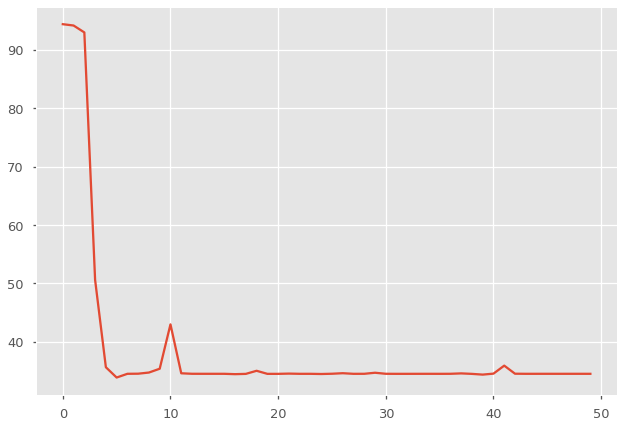

In [247]:
plt.plot(Trainer.lh)
plt.show()

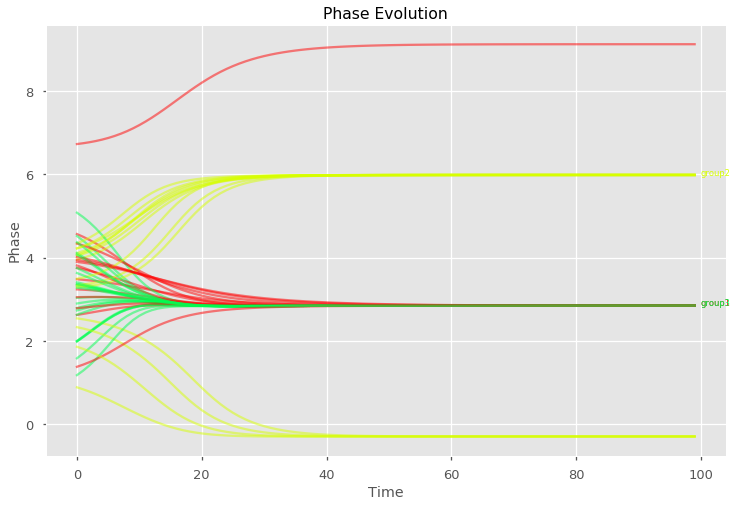

In [249]:
bs=50
a,idx = gmm.sample(bs)
masks = torch.FloatTensor(bs,4).zero_()
masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
Trainer.init_phase(bs)
features, couplings  = Model(Trainer.init,a.float())
phase_evol(features.detach(),masks.unsqueeze(0).data.numpy())

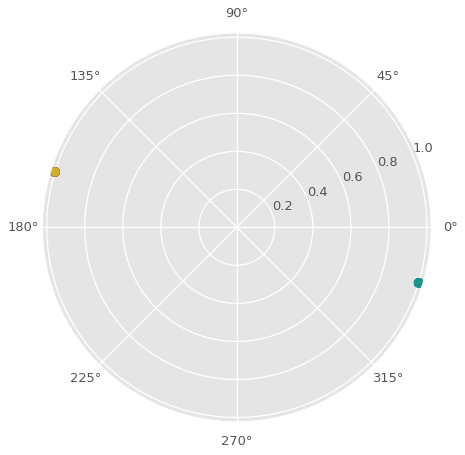

In [251]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.scatter(features[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
plt.show()

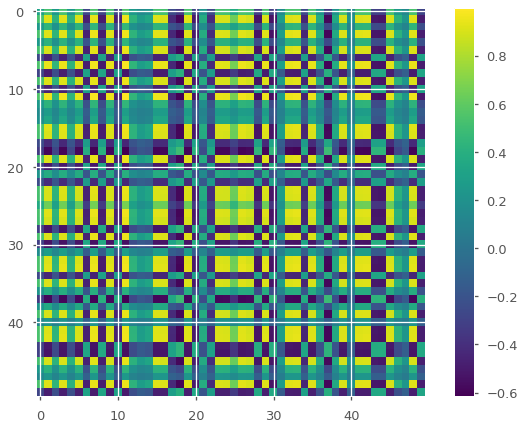

In [252]:
plt.imshow(couplings.detach().numpy())
plt.colorbar()
plt.show()

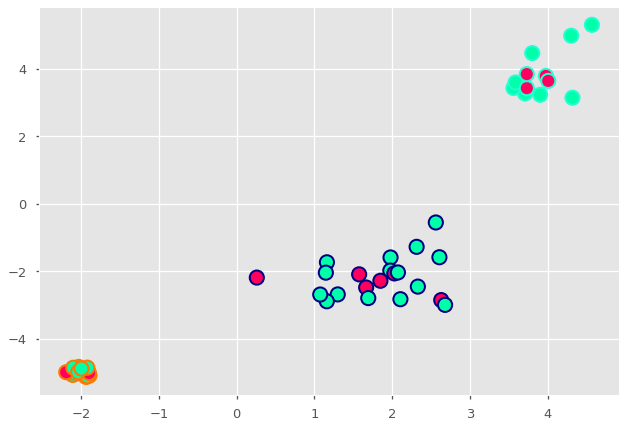

In [265]:
from matplotlib import cm
a,idx = gmm.sample(bs)
ecolors = [cm.jet(x*100) for x in idx]
colors = [cm.hsv(x) for x in (features[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
plt.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)

In [260]:
idx

tensor([2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 2, 1,
        2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0,
        0, 0])

## Optimizing couplings directly

In [143]:
class Kuramoto_couplings(nn.Module):
    """
    Kuramoto dynamics with adaptative solver
    """
    def __init__(self,
                 batch_size = 32,
                 num_hid = 32,
                 input_size = 2,
                 feature_size = 10,
                 device='cpu'):
        
        super(Kuramoto_couplings, self).__init__()
  
        #Integration parameters
        self.integration_time =  torch.linspace(0., 20, 100).float()
        self.ODEDynamic = KuraODE()
        self.tol = 1e-5
        self.atol = 1e-5
        self.max_steps = 1000
        
        #Problem dimensions
        self.batch_size = batch_size
        self.indim = input_size
        self.outdim = feature_size
        self.device = device

        # Definition of couplings
        self.couplings = torch.nn.Parameter(torch.rand(batch_size,batch_size),requires_grad=True)
        
    def forward(self,init_phase):
        
        self.ODEDynamic.update(self.couplings)
        
        #Run Dynamic with adaptative solver
        trajectory = odeint_adjoint(self.ODEDynamic, init_phase, self.integration_time,
                                 rtol=self.tol, atol=self.atol, method='euler')
        
        return trajectory, self.couplings

In [144]:
class KuraTrainer_couplings(object):
    def __init__(self, model, data_generator, batch_size, LossFunc, num_features=32):
        super(KuraTrainer_couplings, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.num_features=num_features
        self.model = model
        
    def init_phase(self,batch_size):
        #self.init = torch.zeros((batch_size,)).float().unsqueeze(0)
        self.init = torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0)
        #self.init = torch.FloatTensor(batch_size,).uniform_(0, 2*np.pi).unsqueeze(0)
        return self.init
        #return torch.normal(np.pi,0.05,(batch_size,)).float().unsqueeze(0)
    
    
    def plot_data(self,num_points):
        a, idx = self.data_generator.sample(num_points)
        plt.scatter(a[:,0],a[:,1],c=idx)
        plt.show()
    
    def train(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False, eps=1e-12,num_loss=0):
        self.lh = []
        opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.init_phase(self.batch_size)
        batch, idx = self.data_generator.sample(self.batch_size)
        masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
        for _ in range(gradient_steps):
            
            init_phase = self.init #self.init_phase(self.batch_size)
            
            #Training by gradient descent via adjoint sensitivity method
            opt.zero_grad()
            phase, couplings = self.model(init_phase)
            loss = LossFunc(phase, masks,split=True)
            print(' step : ', _,'Loss : ', loss)
            self.lh.append(loss[num_loss].detach().numpy())
            loss[num_loss].backward()
            self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
            opt.step()
        return
    
    def phase_evol(self,phase, mask):
        return

In [150]:
bs = 100
Model = Kuramoto_couplings(batch_size = bs, num_hid = 100,input_size=2, feature_size=20, device='cpu')
gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-2,-5]], cov_matrices=[0.5*np.eye(2),0.2*np.diag([1,3]),0.01*np.eye(2)])
#gmm = GMM(n_components=4, centroids=[[2,-2],[4,4],[-3,3],[-2,-5]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,3]),0.02*np.eye(2),0.01*np.eye(2)])
#gmm = GMM(n_components=2, centroids=[[2,-2],[-2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
LossFunc = circular_moments_batch
#LossFunc = cohn_loss
Trainer = KuraTrainer_couplings(Model, gmm, LossFunc=LossFunc, batch_size=bs)
Trainer.train(gradient_steps=50,lr=0.05,num_loss=0)

 step :  0 Loss :  (tensor(94.4996, grad_fn=<MeanBackward0>), tensor(4.0495e-06, grad_fn=<MeanBackward0>), tensor(188.9991, grad_fn=<MeanBackward0>))
 step :  1 Loss :  (tensor(94.4950, grad_fn=<MeanBackward0>), tensor(7.9894e-06, grad_fn=<MeanBackward0>), tensor(188.9900, grad_fn=<MeanBackward0>))
 step :  2 Loss :  (tensor(94.4808, grad_fn=<MeanBackward0>), tensor(1.7555e-05, grad_fn=<MeanBackward0>), tensor(188.9616, grad_fn=<MeanBackward0>))
 step :  3 Loss :  (tensor(94.4391, grad_fn=<MeanBackward0>), tensor(4.0908e-05, grad_fn=<MeanBackward0>), tensor(188.8782, grad_fn=<MeanBackward0>))
 step :  4 Loss :  (tensor(94.3222, grad_fn=<MeanBackward0>), tensor(9.5705e-05, grad_fn=<MeanBackward0>), tensor(188.6443, grad_fn=<MeanBackward0>))
 step :  5 Loss :  (tensor(94.0078, grad_fn=<MeanBackward0>), tensor(0.0002, grad_fn=<MeanBackward0>), tensor(188.0154, grad_fn=<MeanBackward0>))
 step :  6 Loss :  (tensor(93.1873, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), t

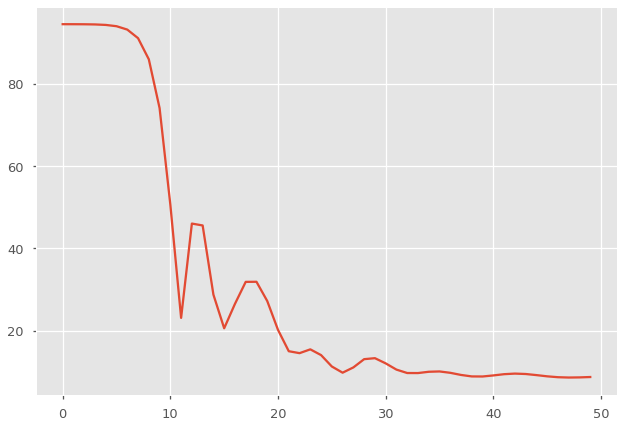

In [151]:
plt.plot(Trainer.lh)
plt.show()

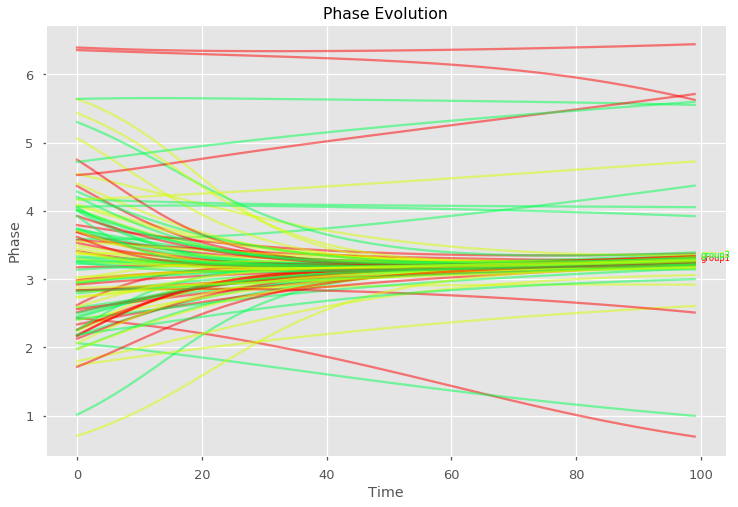

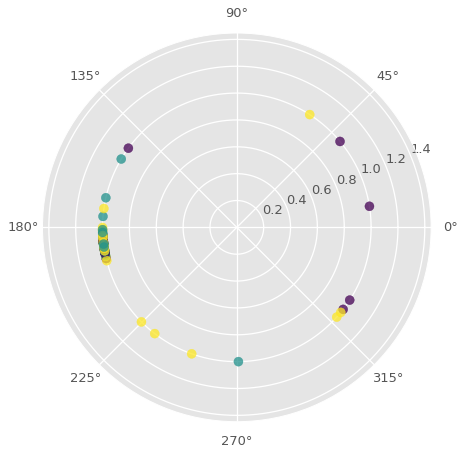

In [152]:
bs=100
a,idx = gmm.sample(bs)
masks = torch.FloatTensor(bs,4).zero_()
masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
Trainer.init_phase(bs)
features, couplings  = Model(Trainer.init)
phase_evol(features.detach(),masks.unsqueeze(0).data.numpy())

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.scatter(features[-1].squeeze(0).detach().numpy(), np.ones(len(features)), c=idx, alpha=0.75)
plt.show()


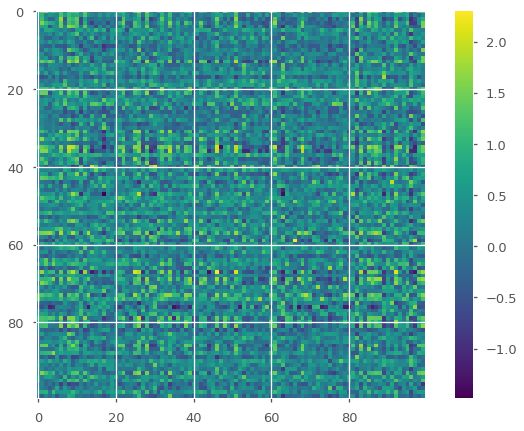

In [154]:
plt.imshow(couplings.detach().numpy())
plt.colorbar()
plt.show()